# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [61]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
import warnings
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn import metrics
from sklearn import preprocessing
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud 

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\rahul\\Desktop\\AI COURSE\\Amazon Fine food\\amazon-fine-food-reviews (1)\\database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm

#Before starting the next phase of preprocessing lets see the number of entries left
final = final.sample(n=100000)
final.shape

print(final.shape)

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

(100000, 10)


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:04<00:00, 1560.92it/s]


In [23]:
preprocessed_reviews[1500]

'lived england seven years learned love heinz beans much expensive grocery stores find ordered cans loose box not like latest shipments received packaged much better cans packaged case plastic preferred much enjoy exceptional beans new improved packaging would rate product good buy new shipping method makes exceptional purchase'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = [] 
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())
    
preprocessed_summary[1500]

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:01<00:00, 1619.62it/s]


'great item improved packaging'

In [26]:
#FEATURE ENGINEERING

## Take length of each review and use it as a feature
review_len = [len(i) for i in preprocessed_reviews]
#Add summary text and review text to extract as much information as possible
# interlist element concatenation 
combined_text = [i +' '+ j for i, j in zip(preprocessed_reviews, preprocessed_summary)] 

len(review_len)

final['combined_text'] = combined_text
final['review_length'] = review_len

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [4,6, 8, 9,10,12,14,17] , and the best `min_samples_split` in range [2,10,20,30,40,50])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [27]:
# Please write all the code with proper documentation
#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

label = final['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

type(final)
print(final.head(3))

#Bag of words using Scikit learn
count_vect = CountVectorizer()
vocab = count_vect.fit(X_train['combined_text'].values)
type(vocab)


# #Using the vocab obtained in train to vectorize both train and test data
X_train_bow = vocab.transform(X_train['combined_text'].values)
X_test_bow = vocab.transform(X_test['combined_text'].values)

print(X_train_bow.shape)

X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)

X_trainf = sparse.vstack((X_train_bow.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_bow.T,X_test_len.T)).T

print(X_trainf.shape)
print(X_testf.shape)

            Id   ProductId          UserId     ProfileName  \
299225  324125  B000GG5J22  A1T3AZLGQXMTOZ   Cathy Quilter   
193883  210199  B001DBRKNA  A3U3OPFXKE9G4Z   yukon sunrise   
145999  158386  B000HDMVNY  A2UCAXUOD7JF6Z  S. M. Saunders   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
299225                     0                       0      1  1281312000   
193883                     0                       0      0  1290470400   
145999                     2                       2      1  1235606400   

                    Summary  \
299225             Tea Time   
193883  crumbly and strange   
145999         Great stuff!   

                                                     Text  \
299225  We love this lemon tea, but we cannot find it ...   
193883  I ordered this a month or 2 ago (from a differ...   
145999  I've been using this product for years - you c...   

                                            combined_text  review_length  
29922

In [83]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate


#function to find the optimal lambda in LR for 5 fold cross validation
def find_optimal_tree(x,y,k):
    
    depth_grid_list = [4,6, 8, 9,10,12,14,17]
    split_grid_list =  [2,10,20,30,40,50]
    
    tuned_parameters = [{'max_depth': depth_grid_list, 'min_samples_split': split_grid_list}]
    model = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), tuned_parameters, scoring = 'roc_auc',n_jobs=-1, cv=k,return_train_score = True)
    model.fit(x,y)
    
    train_scores = model.cv_results_['mean_train_score']
    cv_scores = model.cv_results_['mean_test_score']

    train_scores = np.array(train_scores).reshape(len(depth_grid_list), len(split_grid_list))
    
    train_scores = np.round(train_scores,3)
    
    print("The Heatmap for Train AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(train_scores,cbar_kws={'label': 'colorbar title'}, xticklabels=split_grid_list, yticklabels=depth_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    ax.set_xlabel('Minimum Sample Values')
    ax.set_ylabel('Depth Values')
    plt.show()
    
    cv_scores = np.array(cv_scores).reshape(len(depth_grid_list), len(split_grid_list))
    cv_scores = np.round(cv_scores,3)

    print("The Heatmap for Cross-Validation AUC scores is plotted below: ")
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cv_scores,cbar_kws={'label': 'colorbar title'},xticklabels=split_grid_list, yticklabels=depth_grid_list, linewidths=0.5, linecolor='yellow',annot=True,fmt='g',ax=ax)
    # X - Y axis labels
    ax.set_xlabel('Minimum Sample Values')
    ax.set_ylabel('Depth Values')
    plt.show()
    best = model.best_estimator_
    print("The best model obtained from our Gridsearch is: ",best)
    print("The best parameters obtained by our model is: ",model.best_params_)
    print("The AUC score for our model is is: ",np.round(model.best_score_,3))
    
    return model

#function to predict the label of test data and return the same as list 
def pred_test_data(x_tr,y_tr,x_tst,y_tst,model):
    model.fit(x_tr, y_tr)

    # predict the response
    prob = model.predict_proba(x_tst)[:,1]
    
    pred = model.predict(x_tst)
    # evaluate accuracy
    roc = roc_auc_score(y_tst, prob) * 100
    print('\nThe ROC_AUC score of the Decision Tree classifier is: ', roc)
        
    return pred

# def visulize_tree():
#     tree.export_graphviz(clf,out_file="tree.dot",feature_names = fn,class_names=cn,filled = True)
#     dot -Tpng tree.dot -o tree.png
    
#Function to create Confusion matrix creation and plotting the same
def confusion_heatmap(x,y):
    cnf_mat = confusion_matrix(x,y)
    print("Confusion matrix is : " ,cnf_mat )
    print("The True Positive value is:  ",(cnf_mat[1][1]))
    print("The True Negative value is:  ",(cnf_mat[0][0]))
    print("The False Positive value is:  ",(cnf_mat[1][0]))
    print("The False Negative value is:  ",(cnf_mat[0][1]))
    sns.heatmap(cnf_mat,cbar_kws={'label': 'colorbar title'},cmap='YlGnBu',linewidths=2, linecolor='yellow',annot=True,fmt='g')
    
    
def metric_score(x,y):
    print("The precision score for our model is: ", precision_score(x,y)) 
    print("The f1 score for our model is: ", f1_score(x,y))
    print("The recall score for our model is: ", recall_score(x,y))
    print("The accuracy of our model is: ", accuracy_score(x,y))
        

#Function to plot the the roc_auc curve for train and test data    
def plot_roc_curve(xtrain,prob_train,xtest,prob_test,lin1,lin2,l1,l2):
    train_auc = roc_auc_score(xtrain,prob_train)
    fpr,tpr,_ = roc_curve(xtrain,prob_train)
    plt.figure(figsize=(16,8))
    plt.title('Receiver Operating Characteristic')  
    plt.plot(fpr, tpr, linestyle=lin1, label=l1 )
    test_auc = roc_auc_score(xtest,prob_test)
    fpr,tpr,_ = roc_curve(xtest,prob_test)
    plt.plot(fpr, tpr, linestyle=lin2, label=l2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.legend()
    plt.show()
    
#Function to generate wordcloud given a list of words
def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0 ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


Finding the Optimal Tree using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


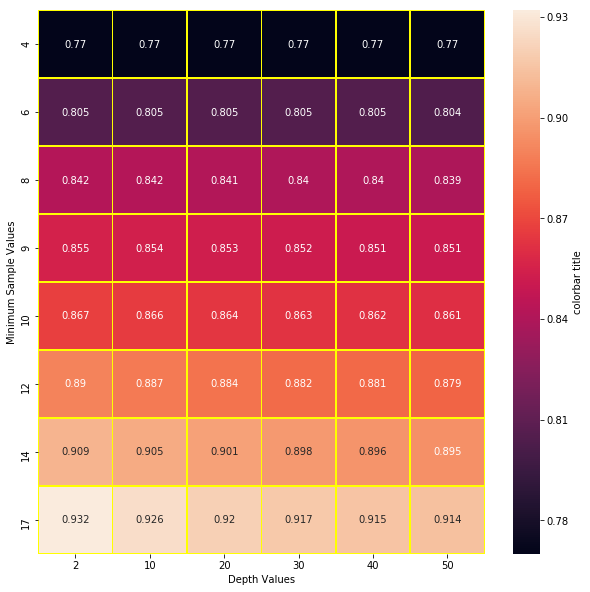

The Heatmap for Cross-Validation AUC scores is plotted below: 


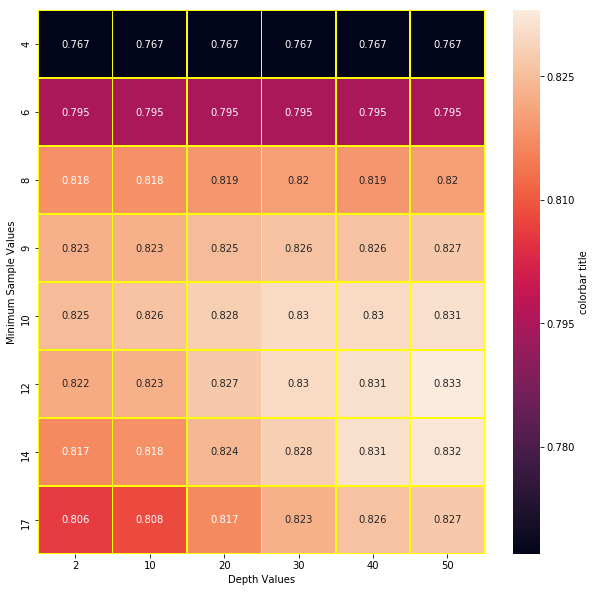

The best model obtained from our Gridsearch is:  DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=12, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The best parameters obtained by our model is:  {'max_depth': 12, 'min_samples_split': 50}
The AUC score for our model is is:  0.833


In [33]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)


# print(X_train)
print("Finding the Optimal Tree using Grid Search: ")
opt_tree = find_optimal_tree(X_trainf,y_en_train,3)

#please excuse that the x axis and y axis labels are interchanged. Though it is a small change in the function retraining the model takes a lot of time hence skipped!!! 

In [84]:
opt_tree_best = opt_tree.best_estimator_

y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_tree_best) 


The ROC_AUC score of the Decision Tree classifier is:  83.2294090359539


Confusion matrix is :  [[ 3898   877]
 [ 6397 18828]]
The True Positive value is:   18828
The True Negative value is:   3898
The False Positive value is:   6397
The False Negative value is:   877


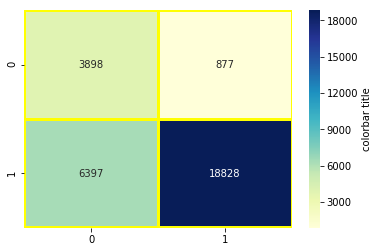

In [85]:
confusion_heatmap(y_en_test,y_pred)

In [86]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9554935295610251
The f1 score for our model is:  0.8381037168929446
The recall score for our model is:  0.746402378592666
The accuracy of our model is:  0.7575333333333333


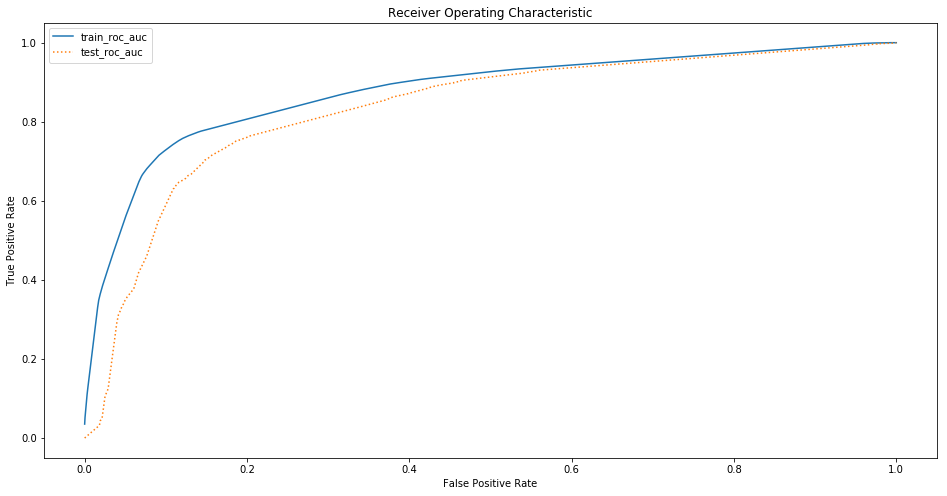

In [87]:
ytrain_prob = opt_tree_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_tree_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

The wordcloud for top 20 features are:


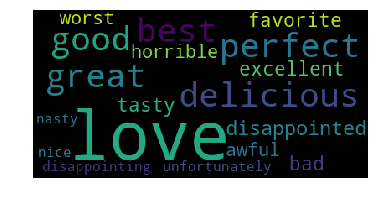

In [88]:
# Please write all the code with proper documentation
#Top 20 features for classification 
#Use negation to sort in descending
top_words_sorted = np.argsort(-opt_tree_best.feature_importances_)
top_text = np.take(count_vect.get_feature_names(), top_words_sorted[:20])

topi_text = " ".join(words for words in top_text)

print("The wordcloud for top 20 features are:")
generate_wordcloud(topi_text)


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

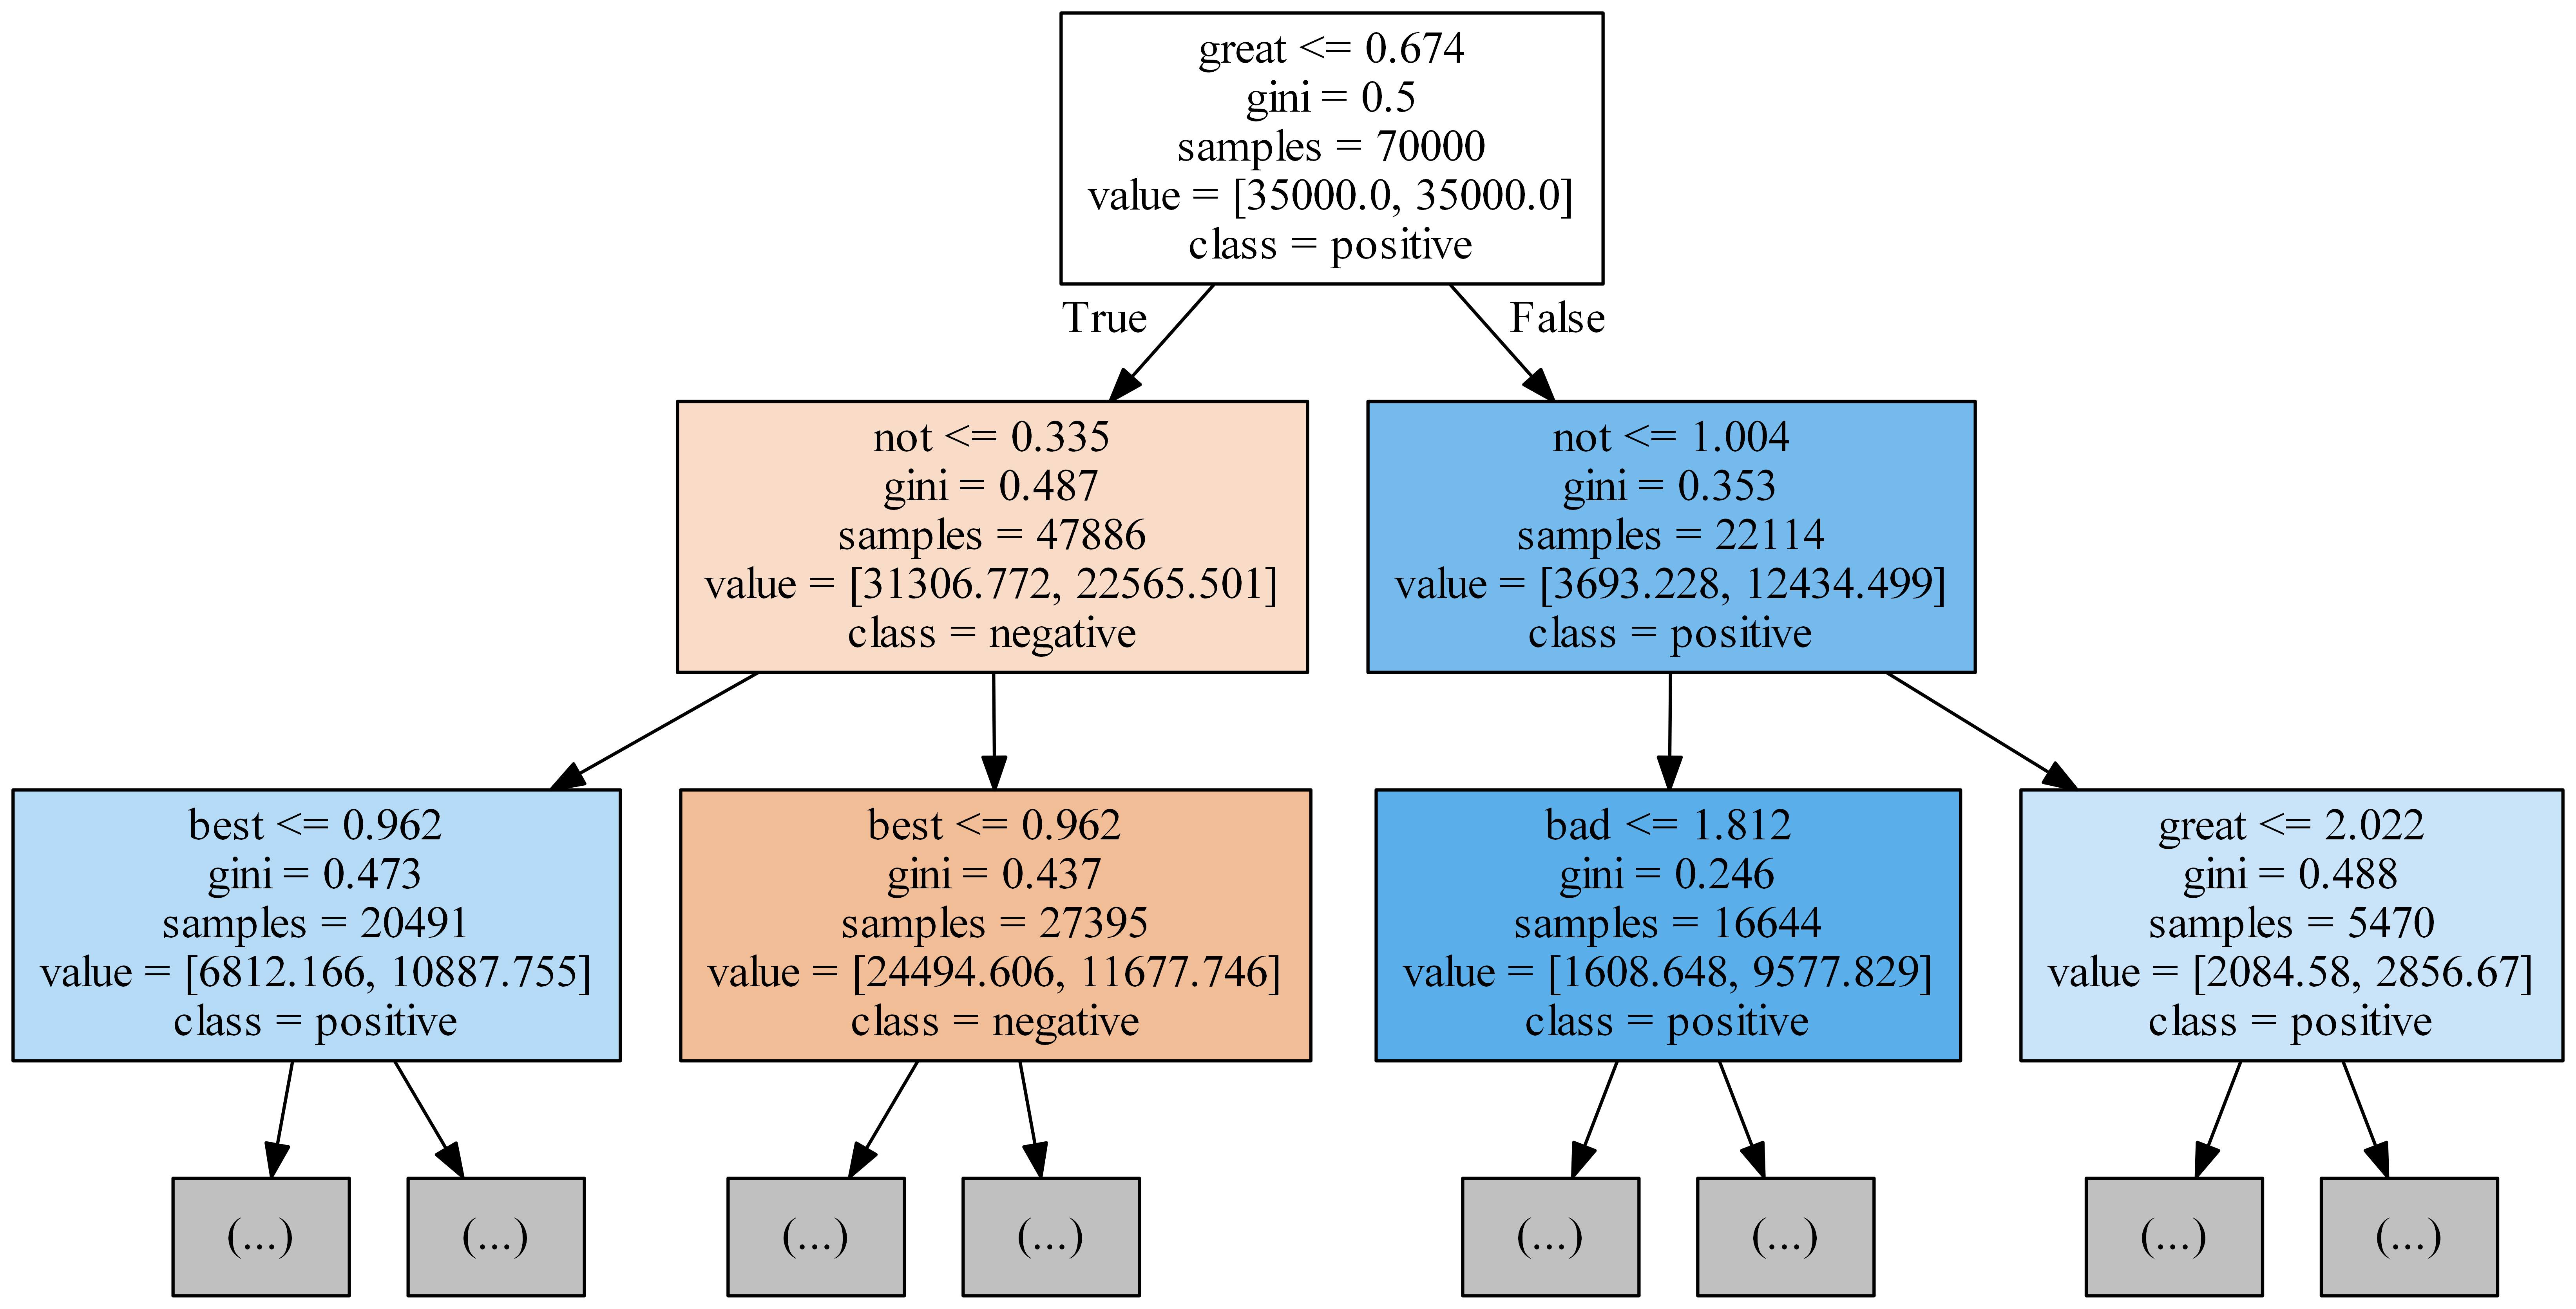

In [90]:
# Please write all the code with proper documentation
#AS we see from above plots that l2 penalty  with alpha value of 1 works best than l2 penalty we will use the same for our model.
features= count_vect.get_feature_names()
features.append('review_length')
opt_tree_best = opt_tree_best.fit(X_trainf,y_en_train)


export_graphviz(opt_tree_best,out_file="tree_bow.dot",feature_names = features,class_names=['negative','positive'],max_depth=2,filled = True)

#SOURCE: https://stackoverflow.com/questions/45984478/using-graphviz-to-plot-decision-tree-in-python
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#SOURCE:https://gist.github.com/WillKoehrsen/ff77f5f308362819805a3defd9495ffd
from subprocess import call
call(['dot', '-Tpng', 'tree_bow.dot', '-o', 'tree_bow.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_bow.png')

Conclusion:
1. Decision Trees with 3-fold validation was performed on a sample dataset of AFF for BOW.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3898 and True Positive value of 18828.
5. The accuracy,precision, recall and f1 scores are 75.75 % , 95.55%, 74.64% and 83.81 % respectively.
6. AS Dtrees give us feature importances, we extracted the top 20 features and presented them in wordcloud.
7. We also visualized the D-tree using Graphviz



## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [91]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab = tf_idf_vect.fit(X_train['combined_text'].values)
X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = vocab.transform(X_test['combined_text'].values)

X_trainf = sparse.vstack((X_train_tfidf.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_tfidf.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 1271298)


Finding the Optimal Tree using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


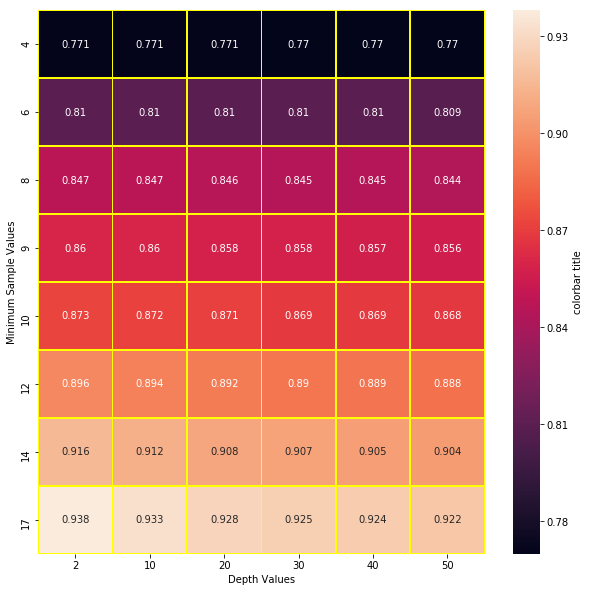

The Heatmap for Cross-Validation AUC scores is plotted below: 


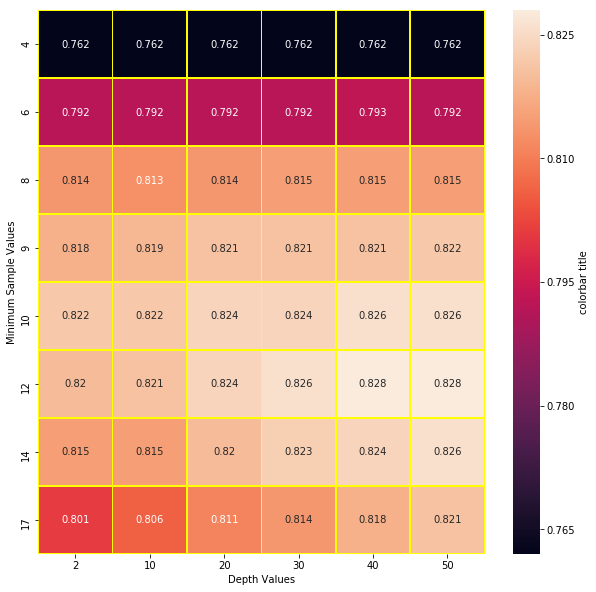

The best model obtained from our Gridsearch is:  DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=12, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=40,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The best parameters obtained by our model is:  {'max_depth': 12, 'min_samples_split': 40}
The AUC score for our model is is:  0.828


In [92]:
encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

# print(X_train)
print("Finding the Optimal Tree using Grid Search: ")
opt_tree = find_optimal_tree(X_trainf,y_en_train,3)

#Kindly excuse the x axis and y axis labels are interchanged. Though it is a small change in the function retraining the model takes a lots of hours hence skipped!!!

In [93]:
opt_tree_best = opt_tree.best_estimator_
y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_tree_best) 


The ROC_AUC score of the Decision Tree classifier is:  82.95583185882035


Confusion matrix is :  [[ 3794   981]
 [ 5771 19454]]
The True Positive value is:   19454
The True Negative value is:   3794
The False Positive value is:   5771
The False Negative value is:   981


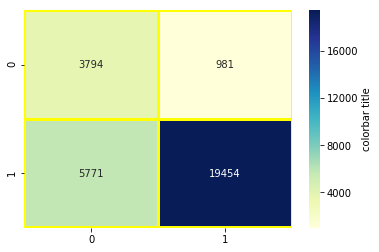

In [94]:
confusion_heatmap(y_en_test,y_pred)

In [95]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9519941277220455
The f1 score for our model is:  0.8521243977222952
The recall score for our model is:  0.7712190287413281
The accuracy of our model is:  0.7749333333333334


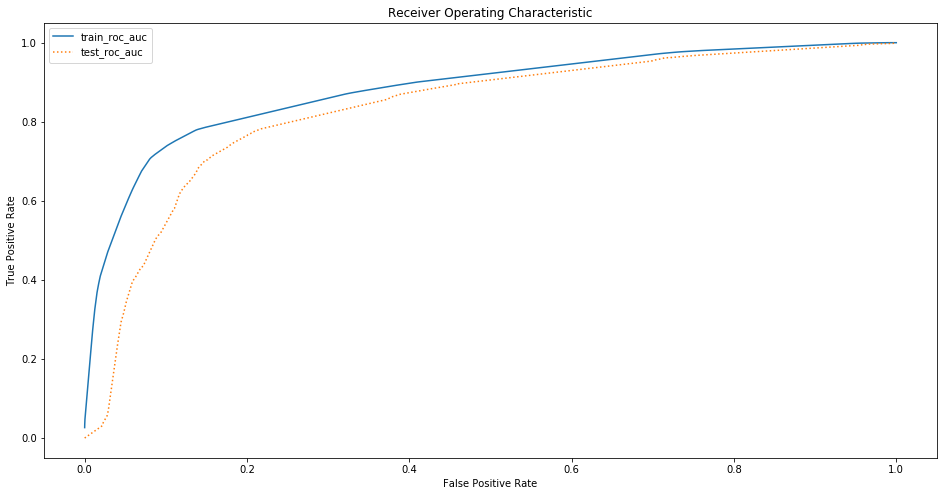

In [96]:
ytrain_prob = opt_tree_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_tree_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

The wordcloud for top 20 features are:


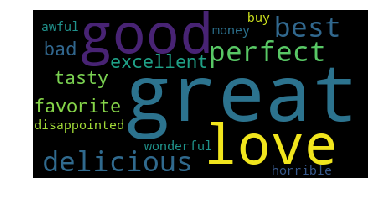

In [98]:
# Please write all the code with proper documentation
#Top 20 features for classification 
#Use negation to sort in descending
top_words_sorted = np.argsort(-opt_tree_best.feature_importances_)
top_text = np.take(tf_idf_vect.get_feature_names(), top_words_sorted[:20])

topi_text = " ".join(words for words in top_text)

print("The wordcloud for top 20 features are:")
generate_wordcloud(topi_text)


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

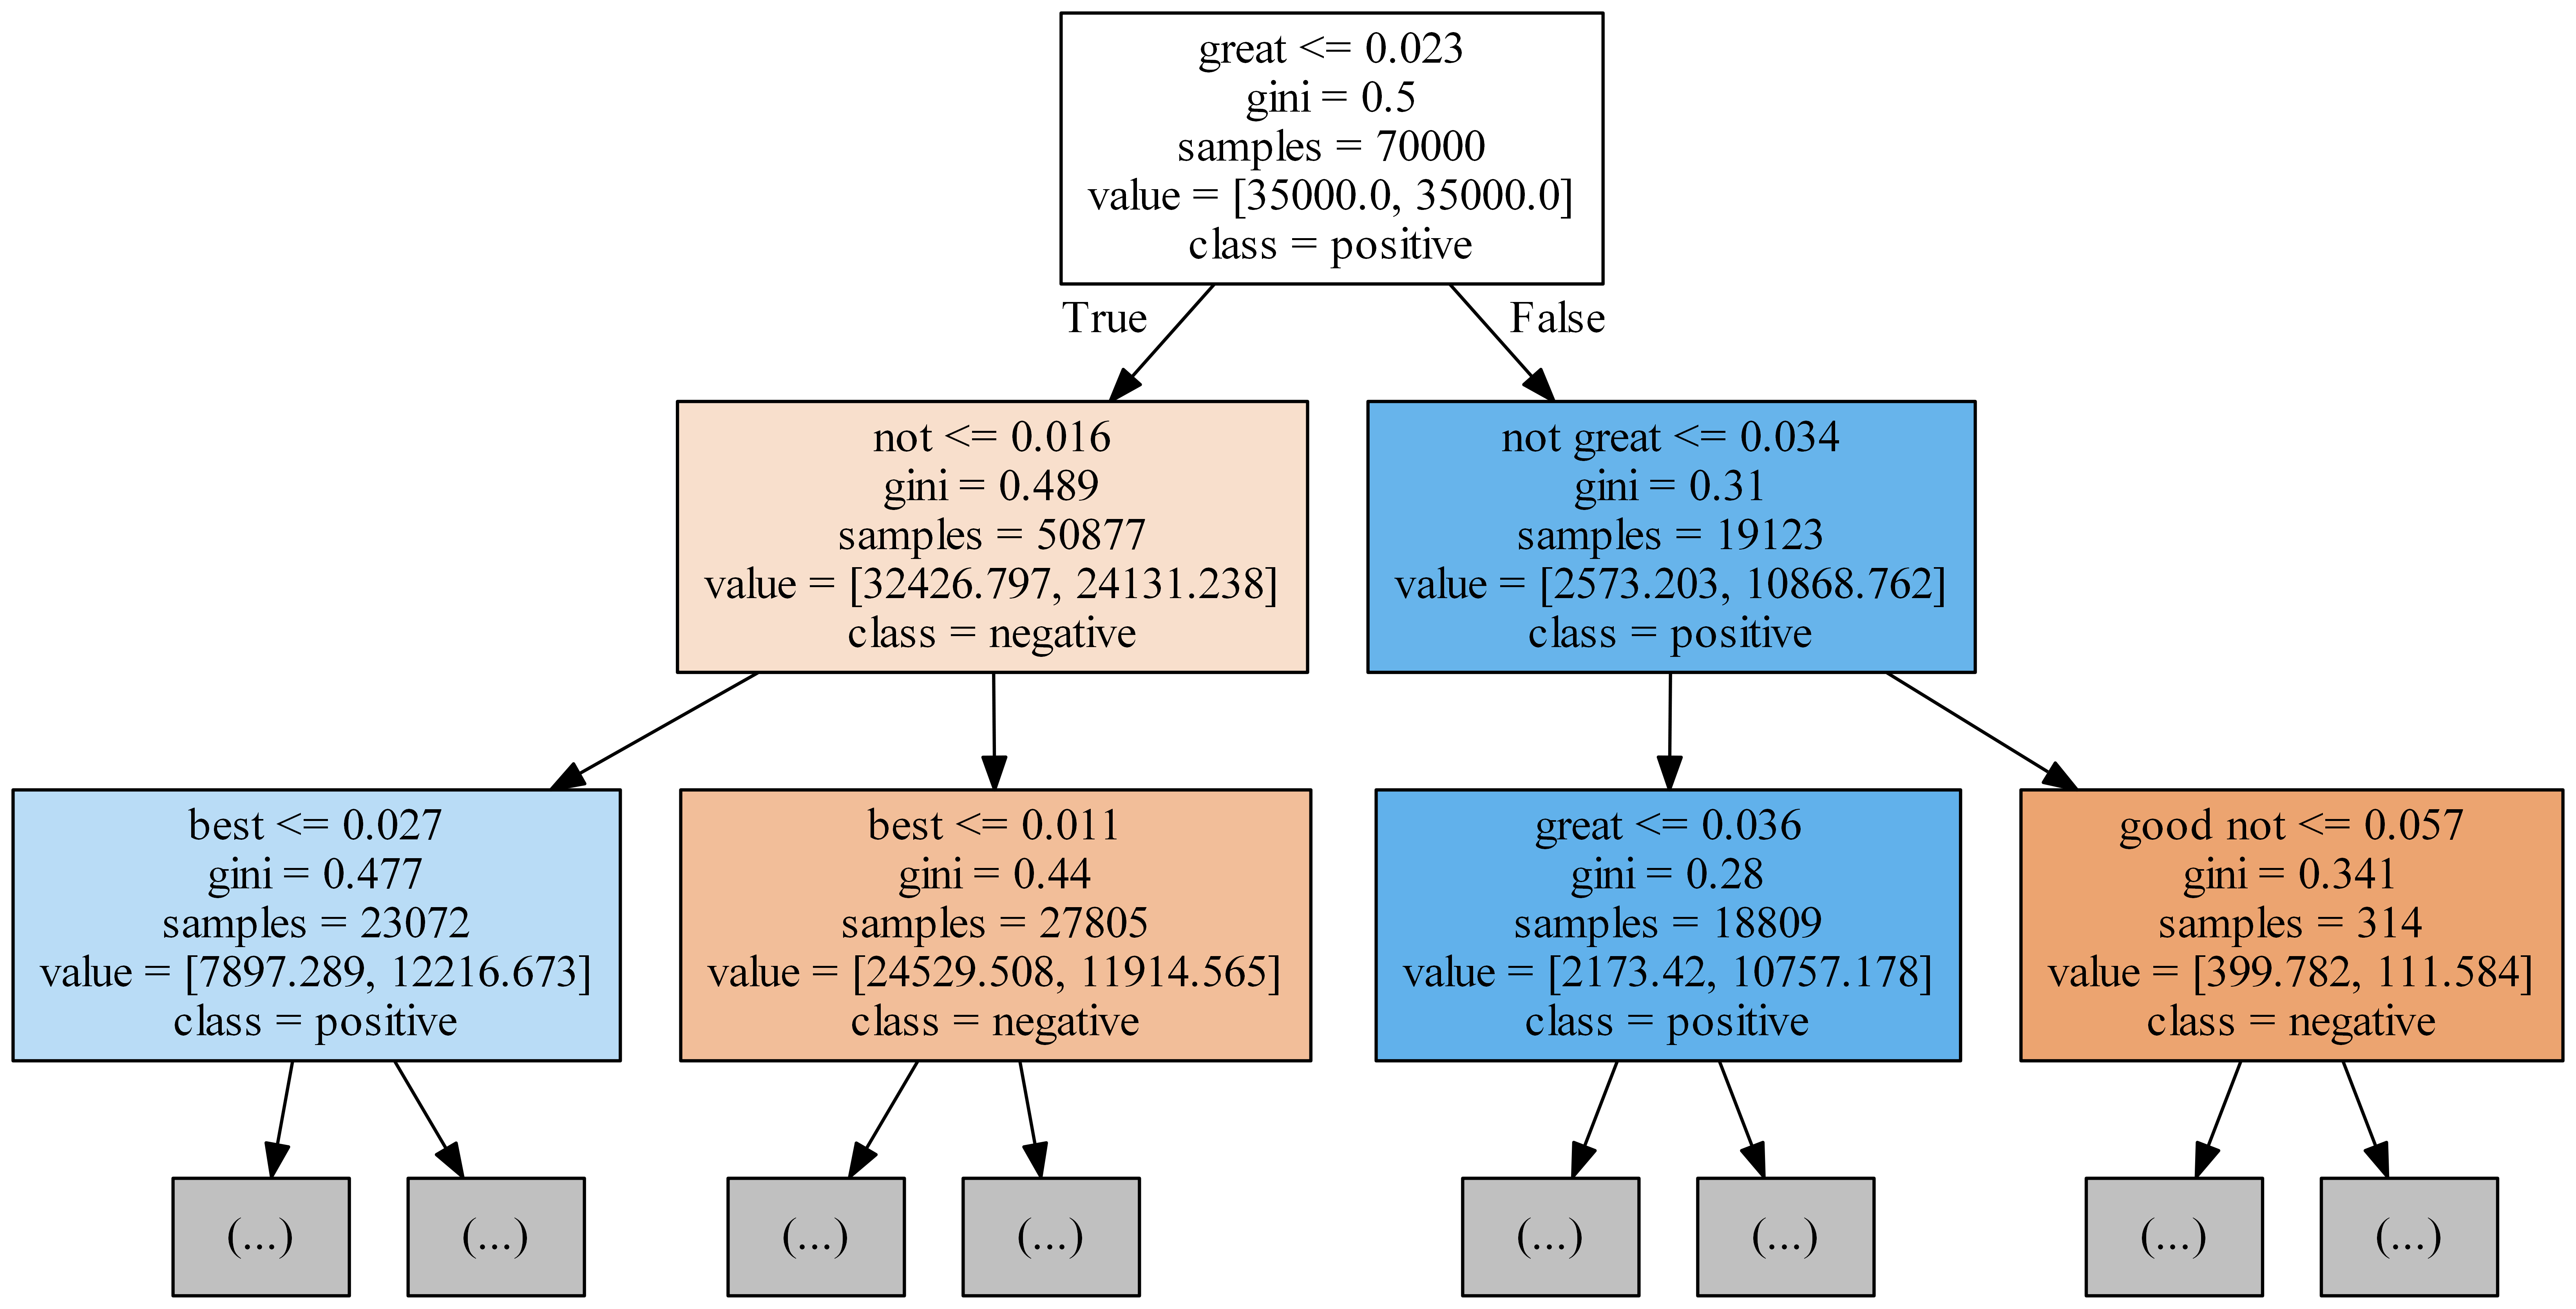

In [99]:
# Please write all the code with proper documentation
#AS we see from above plots that l2 penalty  with alpha value of 1 works best than l2 penalty we will use the same for our model.
features= tf_idf_vect.get_feature_names()
features.append('review_length')
opt_tree_best = opt_tree_best.fit(X_trainf,y_en_train)


export_graphviz(opt_tree_best,out_file="tree_tf_idf.dot",feature_names = features,class_names=['negative','positive'],max_depth=2,filled = True)

#SOURCE:https://gist.github.com/WillKoehrsen/ff77f5f308362819805a3defd9495ffd
call(['dot', '-Tpng', 'tree_tf_idf.dot', '-o', 'tree_tf_idf.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree_tf_idf.png')

Conclusion:
1. Decision Trees with 3-fold validation was performed on a sample dataset of AFF for TF-IDF vectors.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3794 and True Positive value of 19454.
5. The accuracy,precision, recall and f1 scores are 77.49 % , 95.20%,77.12% and 76.92 % respectively.
6. AS Dtrees give us feature importances, we extracted the top 20 features and presented them in wordcloud.
7. We also visualized the D-tree using Graphviz


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [100]:
# Please write all the code with proper documentation
# Train your own Word2Vec model using your own text corpus
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

i=0

list_of_sentance=[]
for sentance in X_train['combined_text']:
    list_of_sentance.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
sent_train_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_train_vectors.append(sent_vec)
print(len(sent_train_vectors))
print(len(sent_train_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [04:22<00:00, 266.56it/s]


70000
50


In [101]:
i=0
list_of_sentance=[]
for sentance in X_test['combined_text']:
    list_of_sentance.append(sentance.split())

# average Word2Vec
# compute average word2vec for each review.
sent_test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_test_vectors.append(sent_vec)
print(len(sent_test_vectors))
print(len(sent_test_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:56<00:00, 258.05it/s]


30000
50


In [102]:
X_train_w2v = np.array(sent_train_vectors)
X_test_w2v = np.array(sent_test_vectors)

X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 51)


Finding the Optimal Tree using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


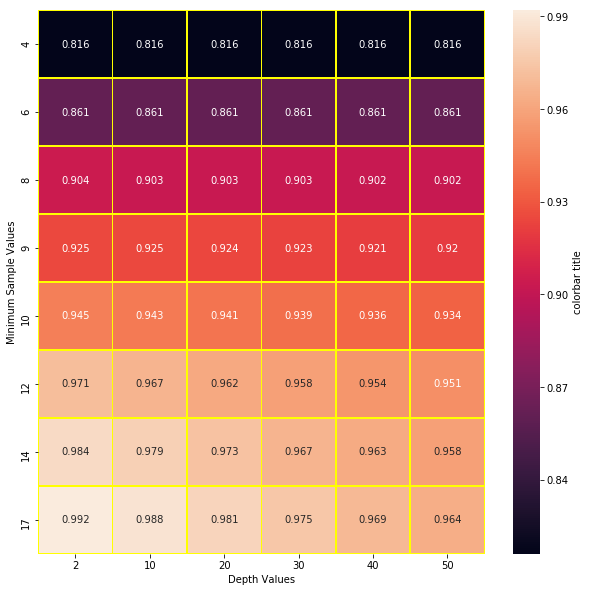

The Heatmap for Cross-Validation AUC scores is plotted below: 


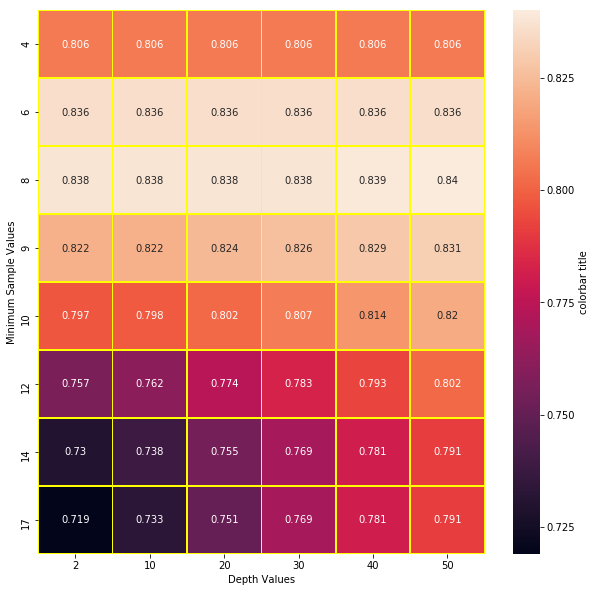

The best model obtained from our Gridsearch is:  DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The best parameters obtained by our model is:  {'max_depth': 8, 'min_samples_split': 50}
The AUC score for our model is is:  0.84


In [103]:
print("Finding the Optimal Tree using Grid Search: ")
opt_tree = find_optimal_tree(X_trainf,y_en_train,3)

In [104]:
opt_tree_best = opt_tree.best_estimator_
y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_tree_best) 


The ROC_AUC score of the Decision Tree classifier is:  84.35940701228213


Confusion matrix is :  [[ 3725  1050]
 [ 5874 19351]]
The True Positive value is:   19351
The True Negative value is:   3725
The False Positive value is:   5874
The False Negative value is:   1050


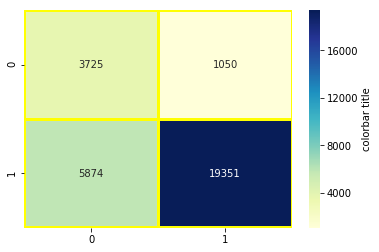

In [105]:
confusion_heatmap(y_en_test,y_pred)

In [106]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9485319347090829
The f1 score for our model is:  0.8482444220400648
The recall score for our model is:  0.7671357779980178
The accuracy of our model is:  0.7692


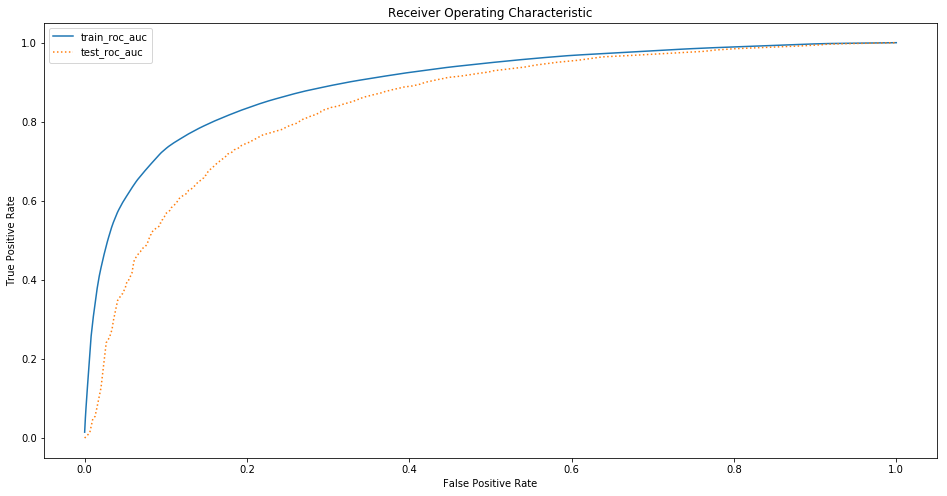

In [107]:
ytrain_prob = opt_tree_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_tree_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

Conclusion:
1. Decision Trees with 3-fold validation was performed on a sample dataset of AFF for Avg Word2vec.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 3725 and True Positive value of 19351.
5. The accuracy,precision, recall and f1 scores are 76.92 % , 94.85%, 76.71% and 76.92 % respectively.


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [108]:
# # Please write all the code with proper documentation
# # TF-IDF weighted Word2Vec

#as it takes a lot of time, after mail consulation with team, taking 10k points
final_tf_w2v = final.sample(n=10000)
label_tf_w2v = final_tf_w2v['Score']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
#fetching the list of sentences from cleanedtext column of our train data for word2vec model    
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
vocab = tf_idf_vect.fit_transform(X_train['combined_text'].values)
# X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = tf_idf_vect.transform(X_test['combined_text'].values)

i=0
list_of_sent=[]
for sent in X_train['combined_text'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
    
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
type(X_train)

tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;


for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
    
X_train_tfw2v = tfidf_train_vectors



100%|██████████████████████████████████████████████████████████████████████████████| 7000/7000 [33:16<00:00,  3.51it/s]


In [109]:
i=0
list_of_sent=[]
for sent in X_test['combined_text'].values:
    list_of_sent.append(sent.split())

tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;

for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
    
X_test_tfw2v = tfidf_test_vectors

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [13:49<00:00,  2.27it/s]


In [110]:
X_train_w2v = np.array(tfidf_train_vectors)
X_test_w2v = np.array(tfidf_test_vectors)

X_train, X_test, y_train, y_test = cross_validation.train_test_split(final_tf_w2v, label_tf_w2v, test_size=0.3, random_state=0)
X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)


X_trainf = sparse.vstack((X_train_w2v.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_w2v.T,X_test_len.T)).T

print(X_trainf.shape)

(7000, 51)


Finding the Optimal Tree using Grid Search: 
The Heatmap for Train AUC scores is plotted below: 


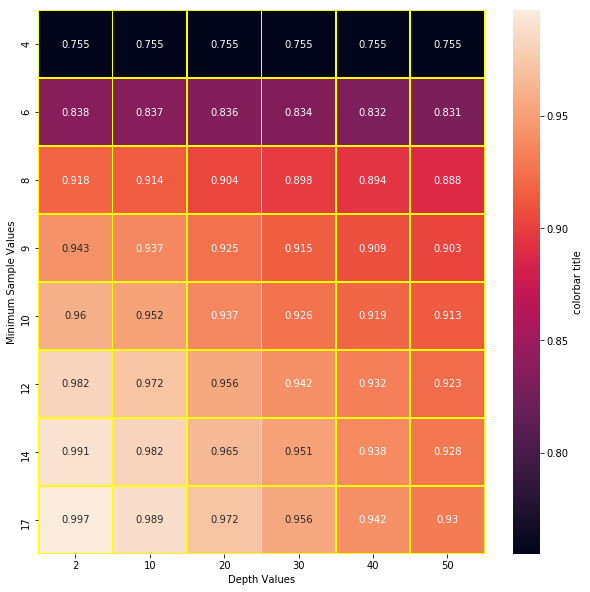

The Heatmap for Cross-Validation AUC scores is plotted below: 


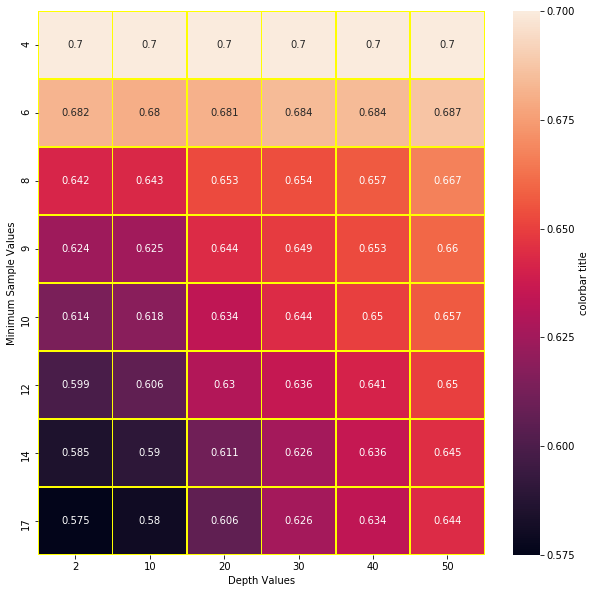

The best model obtained from our Gridsearch is:  DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
The best parameters obtained by our model is:  {'max_depth': 4, 'min_samples_split': 2}
The AUC score for our model is is:  0.7


In [112]:
# find the optimal plane using grid search 

encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

print("Finding the Optimal Tree using Grid Search: ")
opt_tree = find_optimal_tree(X_trainf,y_en_train,3)

In [113]:
opt_tree_best = opt_tree.best_estimator_
y_pred = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_tree_best) 


The ROC_AUC score of the Decision Tree classifier is:  69.92646846378318


Confusion matrix is :  [[ 296  202]
 [ 712 1790]]
The True Positive value is:   1790
The True Negative value is:   296
The False Positive value is:   712
The False Negative value is:   202


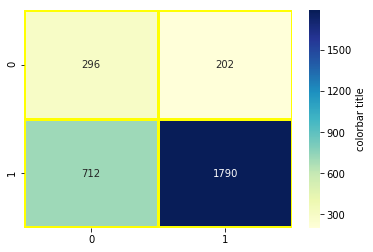

In [114]:
confusion_heatmap(y_en_test,y_pred)

In [115]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.8985943775100401
The f1 score for our model is:  0.796617712505563
The recall score for our model is:  0.715427657873701
The accuracy of our model is:  0.6953333333333334


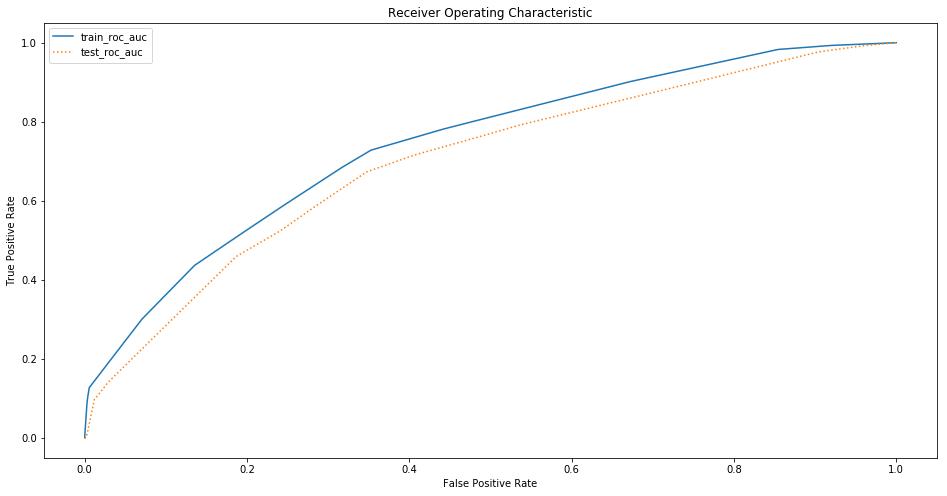

In [116]:
ytrain_prob = opt_tree_best.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = opt_tree_best.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

Conclusion:
1. Decision Trees with 3-fold validation was performed on a sample dataset of AFF for TF-IDF weighted Word2vec.
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
4. Confusion matrix was plotted for the same. We got True Negative value of 296 and True Positive value of 1790.
5. The accuracy,precision, recall and f1 scores are 69.53 % , 89.96%, 71.52% and 79.66% respectively.


# [6] Conclusions

In [117]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
    
x = PrettyTable(["METRIC", "B.O.W", "TF-IDF", "Avg w2v", "TF-IDF w2v"])

x.add_row(["Depth",12,12,8,4])
x.add_row(["Min Samples",50,40,50,2])
x.add_row(["True Positive",18828,19454,19351,1790])
x.add_row(["True Negative",3898,3794,3725,296 ])
x.add_row(["Accuracy",75.75,77.49,76.92,69.53 ])
x.add_row(["Precision",95.55,95.20,94.85,89.96 ])
x.add_row(["Recall",74.64,77.12,76.71,71.52 ])
x.add_row(["F1 Scores",83.81,85.21,76.92,79.66 ])
x.add_row(["AUC Scores",83.23,82.95,84.36,69.92 ])

print(x)

+---------------+-------+--------+---------+------------+
|     METRIC    | B.O.W | TF-IDF | Avg w2v | TF-IDF w2v |
+---------------+-------+--------+---------+------------+
|     Depth     |   12  |   12   |    8    |     4      |
|  Min Samples  |   50  |   40   |    50   |     2      |
| True Positive | 18828 | 19454  |  19351  |    1790    |
| True Negative |  3898 |  3794  |   3725  |    296     |
|    Accuracy   | 75.75 | 77.49  |  76.92  |   69.53    |
|   Precision   | 95.55 |  95.2  |  94.85  |   89.96    |
|     Recall    | 74.64 | 77.12  |  76.71  |   71.52    |
|   F1 Scores   | 83.81 | 85.21  |  76.92  |   79.66    |
|   AUC Scores  | 83.23 | 82.95  |  84.36  |   69.92    |
+---------------+-------+--------+---------+------------+
